# Практикум 11

In [1]:
import __main__
from IPython.display import Image
__main__.pymol_argv = [ 'pymol', '-x' ] # открыть pymol  без использования внешнего GUI
import pymol
pymol.finish_launching()
from pymol import cmd,stored
import numpy as np
import time
import pandas as pd

Продемонстрирую последовательность команд, которую я выполняла чтобы получить необходимые для молекулярной динамики файлы.

Перейдем в директорию, в которой будем выполнять команды и загрузим пути к необходимым программам


In [9]:
%%bash
cd ../Perevoshchikova/
source /home/preps/golovin/progs/bin/GMXRC.bash

Создаем ячейку с 64 липидами 

In [ ]:
%%bash
gmx genconf -f dppc.gro -o b_64.gro -nbox 4 4 4

Создаем pdb файлы из dppc.gro и b_64.gro

In [11]:
%%bash
editconf -f ../Perevoshchikova/dppc.gro -o ../Perevoshchikova/dppc.pdb
editconf -f ../Perevoshchikova/b_64.gro -o ../Perevoshchikova/b_64.pdb

Read 50 atoms
Volume: 1.5477 nm^3, corresponds to roughly 600 electrons
No velocities found
Read 3200 atoms
Volume: 99.0529 nm^3, corresponds to roughly 44500 electrons
No velocities found


                         :-)  G  R  O  M  A  C  S  (-:

                       GRowing Old MAkes el Chrono Sweat

                            :-)  VERSION 4.5.5  (-:

        Written by Emile Apol, Rossen Apostolov, Herman J.C. Berendsen,
      Aldert van Buuren, Pär Bjelkmar, Rudi van Drunen, Anton Feenstra, 
        Gerrit Groenhof, Peter Kasson, Per Larsson, Pieter Meulenhoff, 
           Teemu Murtola, Szilard Pall, Sander Pronk, Roland Schulz, 
                Michael Shirts, Alfons Sijbers, Peter Tieleman,

               Berk Hess, David van der Spoel, and Erik Lindahl.

       Copyright (c) 1991-2000, University of Groningen, The Netherlands.
            Copyright (c) 2001-2010, The GROMACS development team at
        Uppsala University & The Royal Institute of Technology, Sweden.
            check out http://www.gromacs.org for more information.

         This program is free software; you can redistribute it and/or
          modify it under the terms of the GNU General Public

Теперь посмотрим на то, что у нас получилось

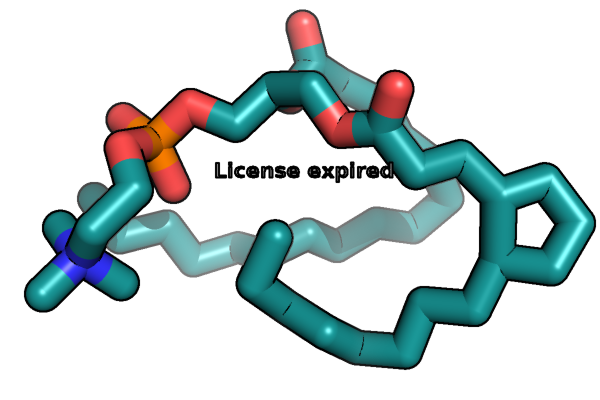

In [12]:
cmd.delete("all")
cmd.bg_color('white')
cmd.do('''load dppc.pdb
as cartoon, all
set stick_radius, 0.5
show stick, all
orient dppc''')
cmd.set("opaque_background", 'off')
cmd.set("ray_trace_mode", '4')
cmd.ray(600,400)
cmd.png('./task11_1.png')
time.sleep(2)
Image(filename='./task11_1.png')

Видим, что у меня истекла лицензия, а файл dppc содержит структуру фосфатидилхолина у которого одна из жирных кислот содержит циклопентановый элемент.

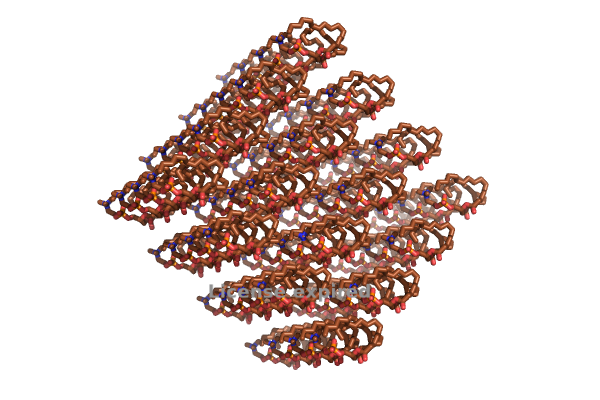

In [42]:
cmd.delete("all")
cmd.bg_color('white')
cmd.do('''load b_64.pdb
as cartoon, all
set stick_radius, 0.5
show stick, all
zoom b_64, complete = 1
turn x, 20
turn y, 20
turn z, 20''')
cmd.set("opaque_background", 'off')
cmd.set("ray_trace_mode", '0')
cmd.ray(600,400)
cmd.png('./task11_2.png')
time.sleep(2)
Image(filename='./task11_2.png', height = 7000, width = 7000)

Видим, что команда gmx genconf -f dppc.gro -o b_64.gro -nbox 4 4 4 создает ячейку 4*4*4, заполненную нашими молекулами липида

Необходимо отредактировать несколько файлов, прежде чем двигаться дальше.

(1) в файле b.top установить количество липидов всистеме 64

(2) в файле с параметрами для молекулярной динамики установим ша по времени 0.004 ps

Сделаем небольшой отступ в ячейке от липидов, чтобы осталось место воде

In [ ]:
%%bash
gmx editconf -f b_64.gro -o b_ec -d 0.5 

Проведем оптимизацию геометрии системы из 64 молекул липида, чтобы удалить плохие контакты воды

In [ ]:
%%bash gmx grompp -f em -c b_ec -p b -o b_em -maxwarn 2
gmx mdrun -deffnm b_em -v

В ходе оптимизации согласно отчету GROMACS, записанному в файле b_em.log потенциальная энергия в ходе 68 шагов уменьшилась с 4.63573e+05 Кдж/моль до -3.11687e+04 Кдж/моль. Правда GROMACS отмечает, что программа "did not reach the requested Fmax < 1". Ну в прочем и ладно, эта наша система еще не окончательная.

Добавим в ячейку молекулы воды

In [ ]:
%%bash 
gmx solvate -cp b_em -p b -cs spc216 -o b_s

Произведем оптимизацию геометрии молекул воды. Часто такая оптимизация из за изначально некорректного положения молекум может привести к появлению больших, действующих на молекулы сил и водяному взрыву.

In [ ]:
%%bash
gmx grompp -f pr -c b_s -p b -o b_pr -maxwarn 1
gmx mdrun -deffnm b_pr -v
#если водяной взрыв, то
gmx grompp -f em -c b_s -p b -o b_empr -maxwarn 1
gmx mdrun -deffnm b_empr -v

gmx grompp -f pr -c b_empr -p b -o b_pr -maxwarn 1
gmx mdrun -deffnm b_pr -v

Теперь переведем файл с добавленной водой b_s.gro и файл с оптимизированной водой b_pr.gro в pdb формат и посмотрим, как это выглядит

In [ ]:
%%bash
editconf -f ../Perevoshchikova/b_s.gro -o ../Perevoshchikova/b_s.pdb
editconf -f ../Perevoshchikova/b_pr.gro -o ../Perevoshchikova/b_pr.pdb

Посмотрим как это выглядит в pymol

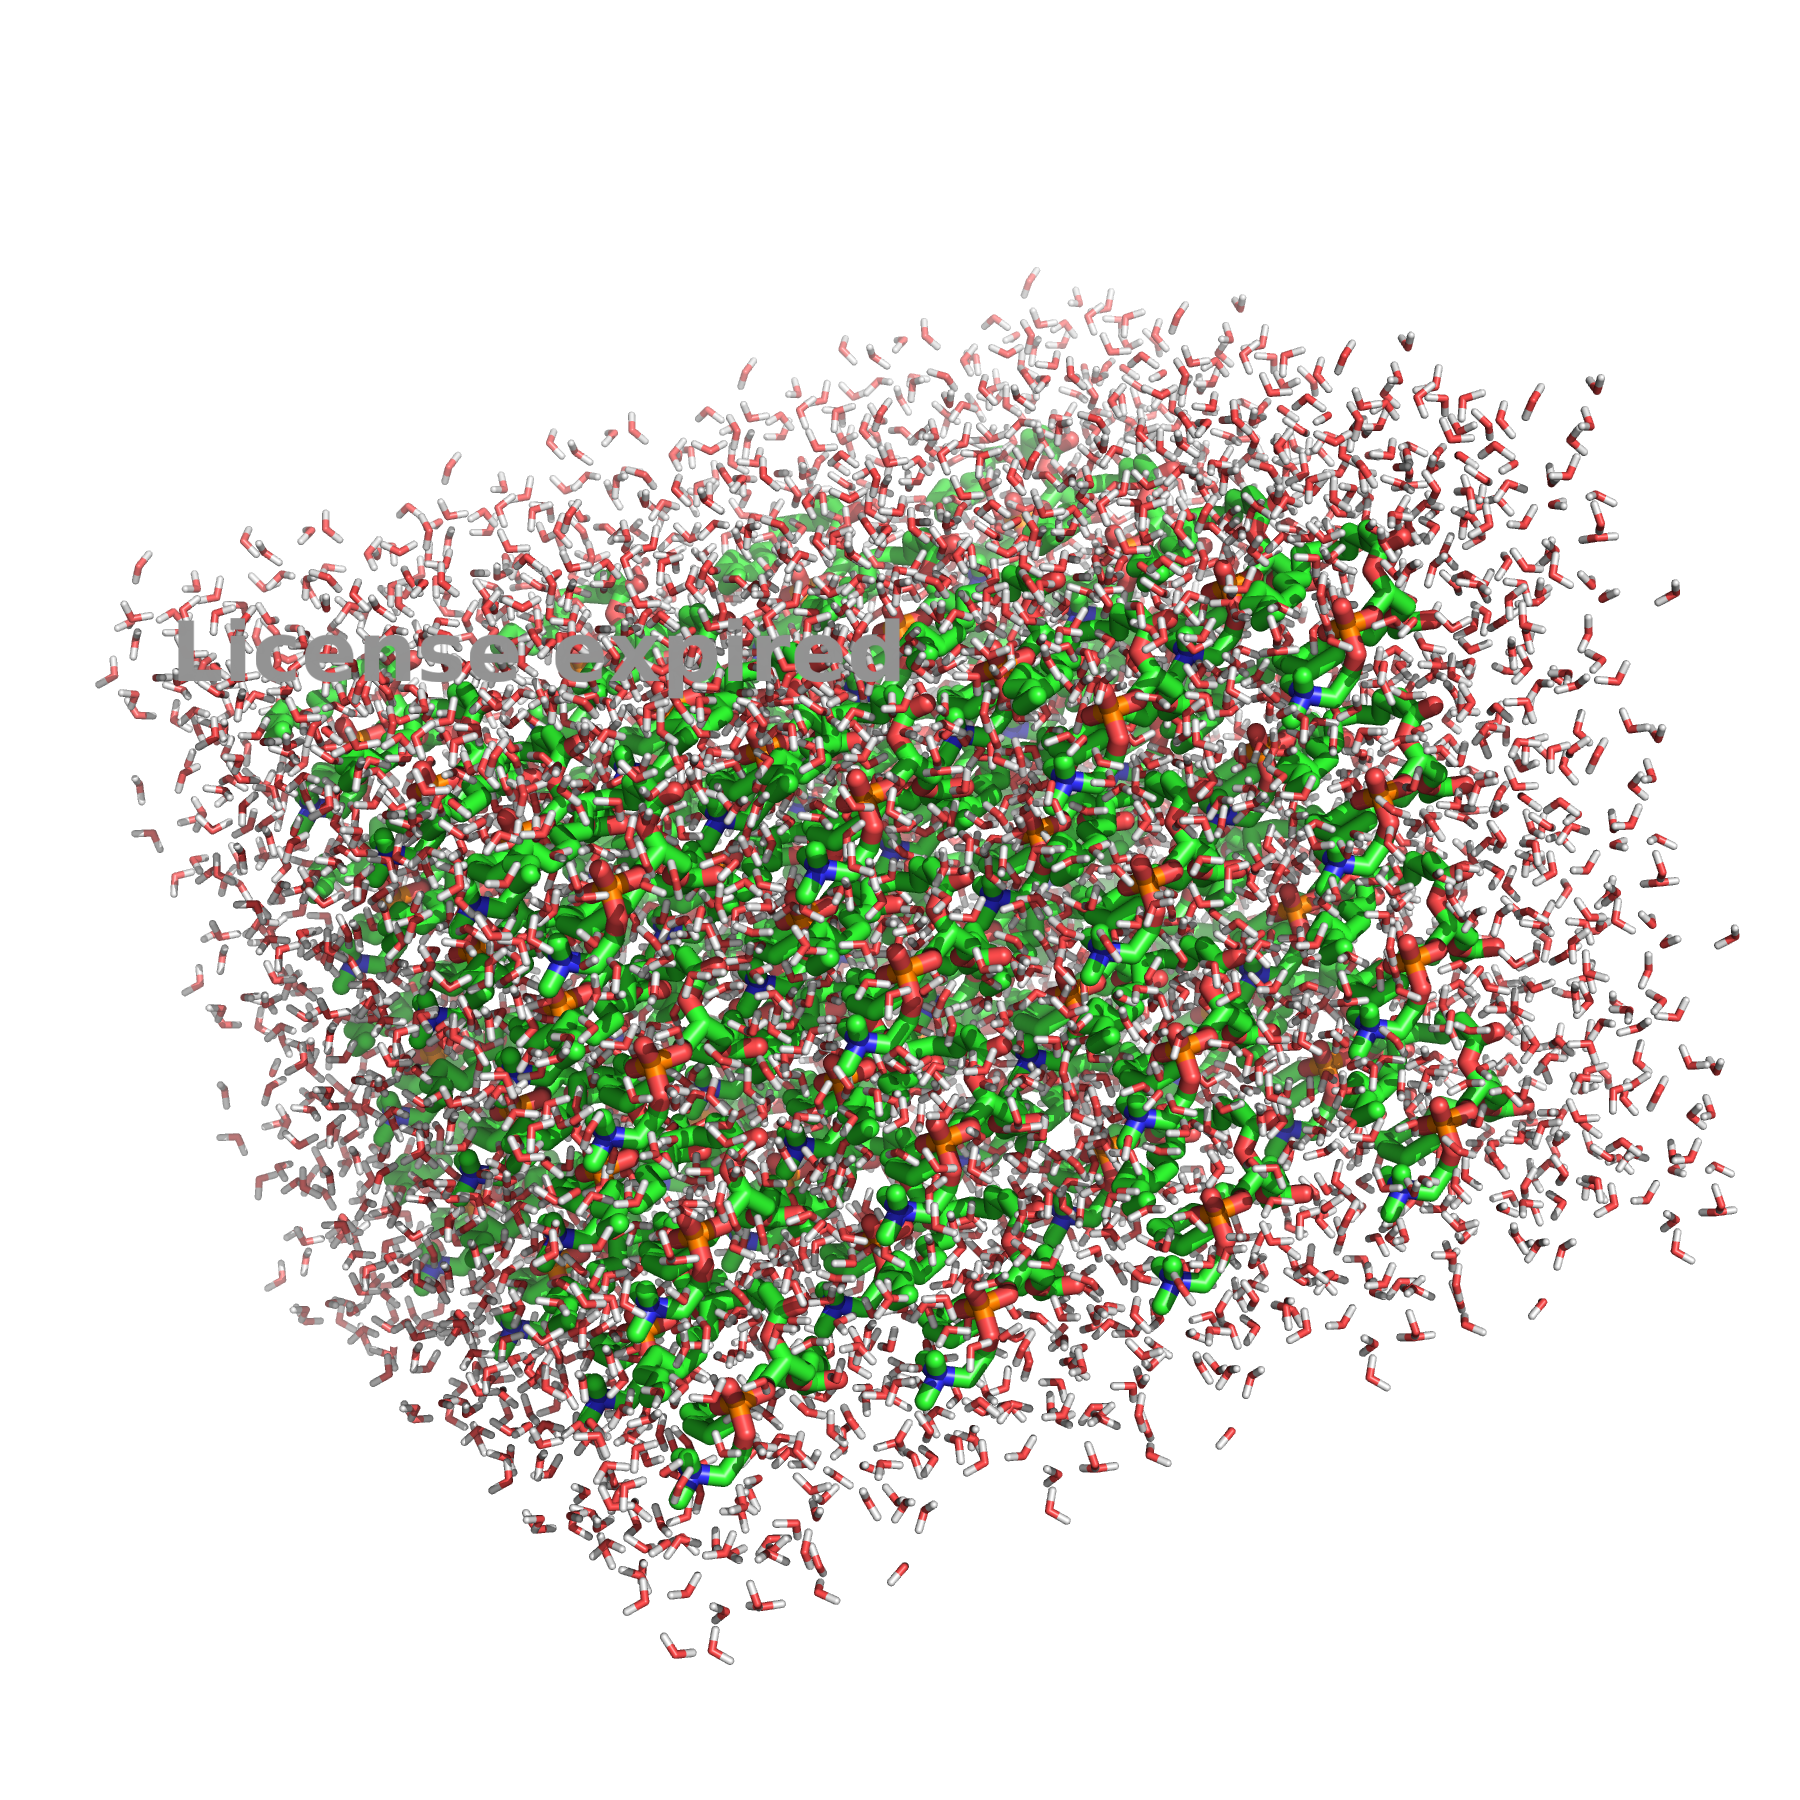

In [47]:
cmd.do("reinitialize")
cmd.delete("all")
cmd.set("ray_trace_mode", '0')
cmd.bg_color('white')
cmd.do('''load b_s.pdb
as cartoon, all
set stick_radius, 0.5
show stick, all
show nonbonded
zoom b_s, complete = 1
turn x, 20
turn y, 20
turn z, 20''')
cmd.ray(1800,1800)
cmd.png('./task11_3.png')
time.sleep(2)
Image(filename='./task11_3.png',
     width = 7000,
     height = 7000)

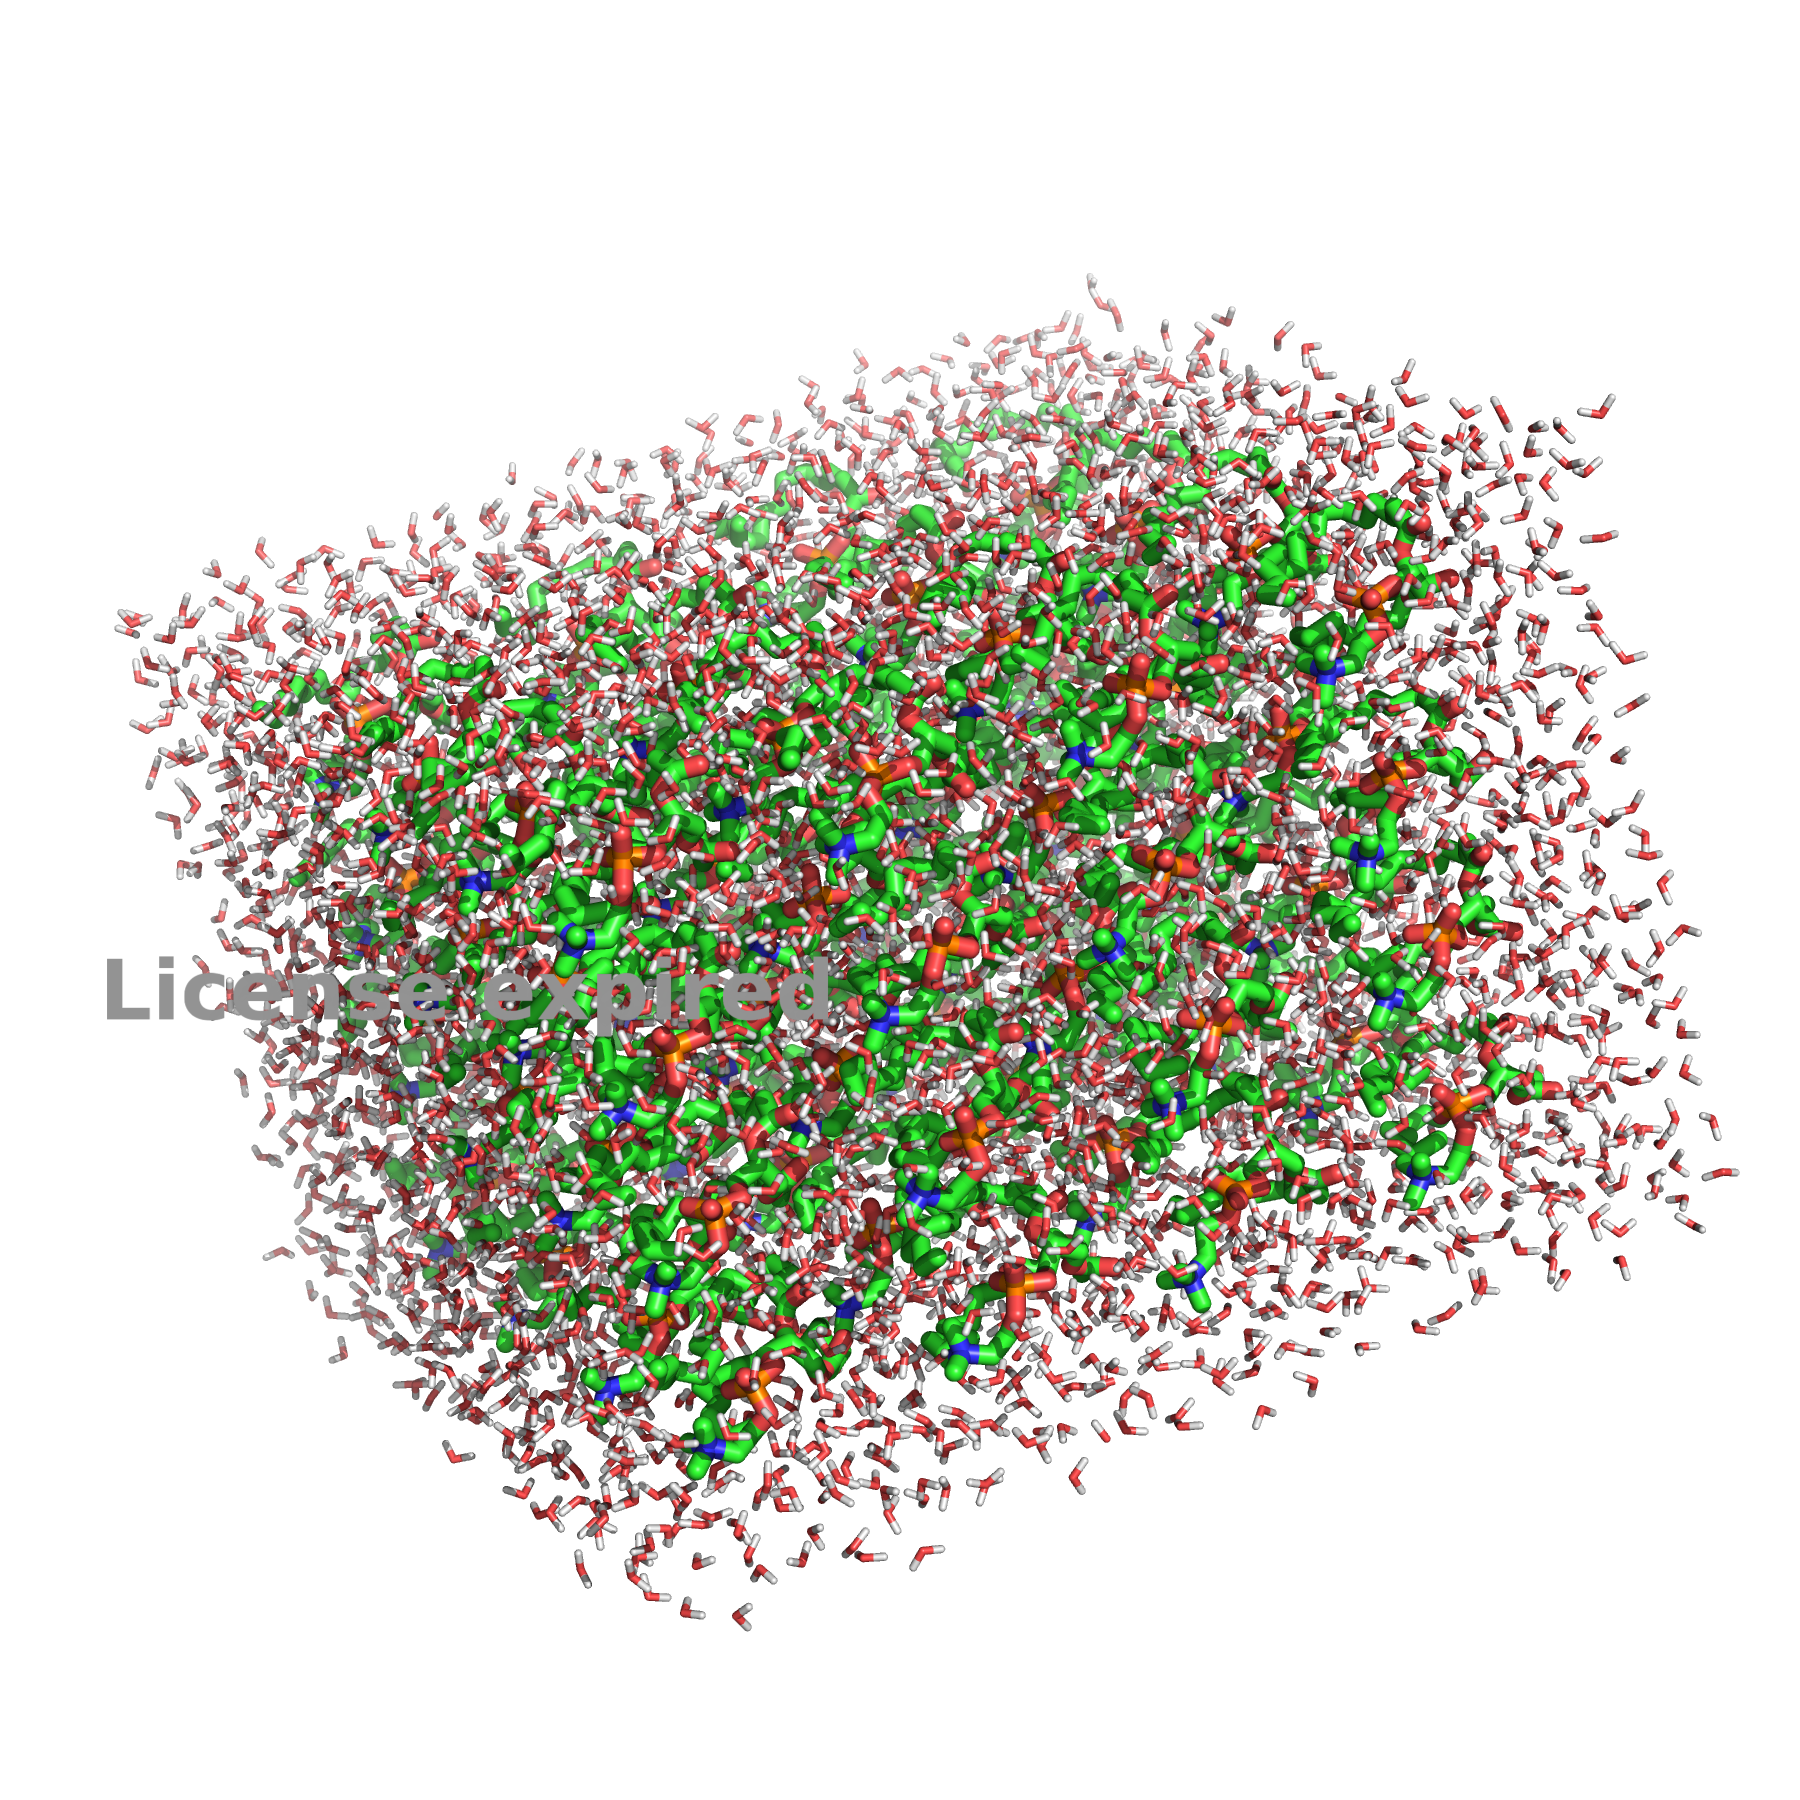

In [48]:
cmd.do("reinitialize")
cmd.delete("all")
cmd.set("ray_trace_mode", '0')
cmd.bg_color('white')
cmd.do('''load b_pr.pdb
as cartoon, all
set stick_radius, 0.5
show stick, all
show nonbonded
zoom b_pr, complete = 1
turn x, 20
turn y, 20
turn z, 20''')
cmd.ray(1800,1800)
cmd.png('./task11_4.png')
time.sleep(2)
Image(filename='./task11_4.png',
     width = 8000,
     height = 7000)

На самом деле видно, что относительно просто добавленной воды - файл b_s молекулы воды поменяли свое положение после оптимизации. На мой взгляд заметно, что в файле, где молекулы воды добавлены случайно (b_s) заметно ноличие странных незаполненных полостей - областей пространства не содержащих молекул. В то время как в структуре b_pr видимых полостей нет, молекулы воды расположены равномерно. К тому же на мой взгляд заметно, что в файле до оптимизации молекулы воды расположены случайно и найти водородную связь довольно сложно в то время как в файле после оптимизации молекулы воды сориентированы оптимально для образования водородной связи.
